## VIT Transformer further insights

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTModel

# Load Vision Transformer model (ViT-L/32)
model_name = "google/vit-large-patch32-224-in21k" 
model = ViTModel.from_pretrained(model_name)
model.num_parameters() / 1e9

model.parameters

<bound method Module.parameters of ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=T

Model is trained on 224x224 images. With 32x32 pixels per patch, it thus has 224/32=7 patches in each dimension. Details for the model can be found at hugging face model hub [here](https://huggingface.co/google/vit-base-patch16-224-in21k).



In [2]:
# from torchvision.datasets import OxfordIIITPet
# import torch
# from torchvision.datasets import OxfordIIITPet
# import matplotlib.pyplot as plt
# from random import random
# from torchvision.transforms import Resize, ToTensor
# from torchvision.transforms.functional import to_pil_image

# to_tensor = [Resize((224, 224)), ToTensor()]

# class Compose(object):
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, target):
#         for t in self.transforms:
#             image = t(image)
#         return image, target

# def show_images(images, num_samples=40, cols=8):
#     """ Plots some samples from the dataset """
#     plt.figure(figsize=(15,15))
#     idx = int(len(dataset) / num_samples)
#     print(images)
#     for i, img in enumerate(images):
#         if i % idx == 0:
#             plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
#             plt.imshow(to_pil_image(img[0]))

# # 200 images for each pet
# dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
# show_images(dataset)

## Correlations of the learned positional encodings

Reproducing Figure 7 in the middle from the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al. (2021).

Getting the positional embeddings.

In [4]:
# Extract position embeddings from the model
position_embeddings = model.embeddings.position_embeddings  # Shape: (1, num_patches + 1, hidden_dim)
position_embeddings = position_embeddings.squeeze(0).detach().numpy()  # Remove batch dim

# Exclude class token (first entry)
position_embeddings = position_embeddings[1:]  # Shape: (num_patches, hidden_dim)
position_embeddings.shape #49, 1024 so allthegther we have 49 patches and C=1024

(49, 1024)

Calculating the correlation matrix of the positional embeddings.

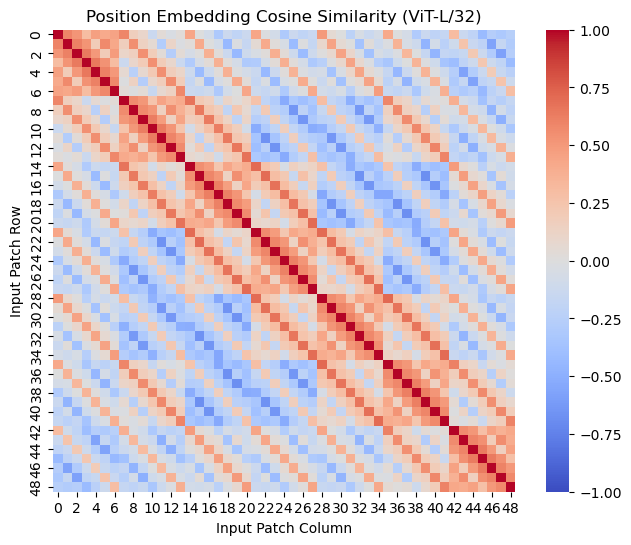

In [5]:
# Compute cosine similarity matrix
def cosine_similarity_matrix(embeddings):
    norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norm  # Normalize each vector
    return np.dot(normalized_embeddings, normalized_embeddings.T)  # Cosine similarity

similarity_matrix = cosine_similarity_matrix(position_embeddings)

# Plot the cosine similarity heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=True)

plt.title("Position Embedding Cosine Similarity (ViT-L/32)")
plt.xlabel("Input Patch Column")
plt.ylabel("Input Patch Row")
plt.show()

Sort them so that the first block is patch 1 and show the correlation matrix to the other 7 patches.

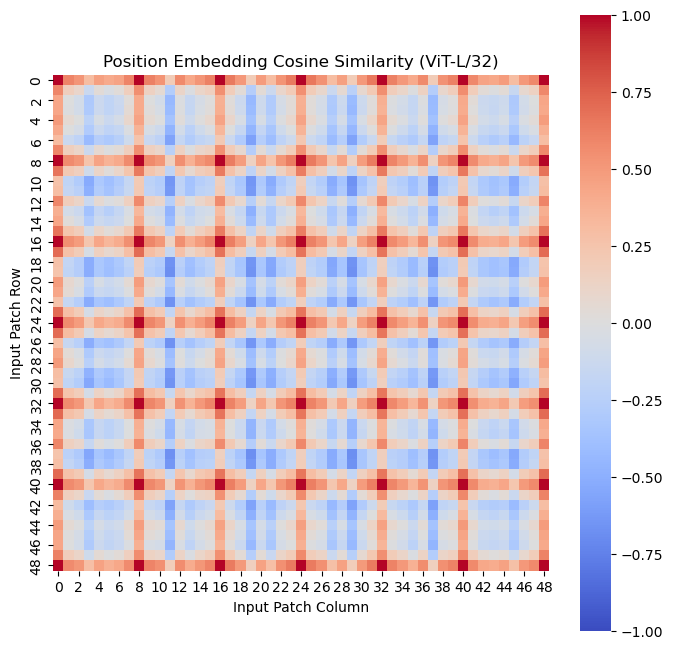

In [6]:
similarity_matrix = cosine_similarity_matrix(position_embeddings)  # Shape: (49, 49)

# Reshape into a (7,7)x(7,7) grid
grid_size = 7
similarity_matrix = similarity_matrix.reshape(grid_size, grid_size, grid_size, grid_size)
similarity_matrix = np.block([[similarity_matrix[i, j] for j in range(grid_size)] for i in range(grid_size)])

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar=True)

plt.title("Position Embedding Cosine Similarity (ViT-L/32)")
plt.xlabel("Input Patch Column")
plt.ylabel("Input Patch Row")
plt.show()

### Visualizing the learned Image Embedding Matrix

First, we look how the embedding is actually done, and find that they use a convolutional layer.

In [7]:
# Extract patch embedding weights
patch_embeddings = model.embeddings.patch_embeddings.projection.weight  
patch_embeddings.shape  # (num_patches, hidden_dim)
# In contrast to the paper the patch embeddings are done by a 2D convolutional layer
model.parameters

<bound method Module.parameters of ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=T

Look at the first new componetnts

In [13]:
# Create a random image tensor (C=3, H=224, W=224)
X = torch.randn(1, 3, 224, 224)  # Add batch dimension (B=1)
from einops.layers.torch import Rearrange
from einops import rearrange
patch_embedding_layer = model.embeddings.patch_embeddings.projection #Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
model.eval() # Set model to evaluation mode
# Apply the 2D convolution (this is how the model embeds patches)
patch_embeddings = model.embeddings.patch_embeddings.projection(X)  # Output shape: (1, 1024, 7, 7) #Still has spatial information
print("Shape of the emdeddings with 2D Convolution: ", patch_embeddings.shape) #B, C, H, W

# Using einops to rearrange the tensor into tensor suited for the transformer
patch_embeddings = Rearrange('b c h w -> b (h w) c')(patch_embeddings)  # Output shape: (1, 49, 1024)
print("Shape of the emdeddings (flattend)", patch_embeddings.shape) #B, T, C
print("First few values of the first patch embedding: ", patch_embeddings[0, 0, :5].detach().numpy())

print("The same with matrix multiplication:")
##### Creating the same using Matrix Multiplication
# Extract patch embedding weights
ET = model.embeddings.patch_embeddings.projection.weight  # Shape: (1024, 3, 32, 32)
ET = Rearrange('c k h w -> c (h w k)')(ET) #k for color, c for embedding size
ET.shape  # (1024, 3*32*32)

X_patch1 = X[:, :, :32, :32]  # First patch (top-left corner)
X_patch_flatten = Rearrange('b c h w -> (b h w c)')(X_patch1) # (32*32*3)

bias = model.embeddings.patch_embeddings.projection.bias  # Shape: (1024,)
patch_embeddings_martix_mult = torch.einsum('ij,j -> i', ET, X_patch_flatten).detach().numpy() + bias.detach().numpy()
print("Shape after the matrix multiplication: ", patch_embeddings_martix_mult.shape) #1024
print("First few values of the first patch embedding: ", patch_embeddings_martix_mult[:5])

Shape of the emdeddings with 2D Convolution:  torch.Size([1, 1024, 7, 7])
Shape of the emdeddings (flattend) torch.Size([1, 49, 1024])
First few values of the first patch embedding:  [-7.826082   -0.08868975  3.2138286   1.6275283   1.5091705 ]
The same with matrix multiplication:
Shape after the matrix multiplication:  (1024,)
First few values of the first patch embedding:  [-7.8260837 -0.0886909  3.2138238  1.6275313  1.5091746]


Now we can to the embedding as a single Matrix multiplication. To find the pattern in the matrix, we can use PCA.

In [40]:
# Compute covariance matrix from patch embeddings
patch_embeddings_np = patch_embeddings[0].detach().numpy()  # Shape: (49, 1024)
cov_matrix = np.cov(patch_embeddings_np, rowvar=False)  # Shape: (1024, 1024)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Get the first 30 eigenvectors and eigenvalues
top_30_eigenvalues = eigenvalues[:30]
top_30_eigenvectors = eigenvectors[:, :30]

# Print the results
print("First 30 Eigenvalues:")
print(top_30_eigenvalues)

print("\nFirst 5 Eigenvectors (each column is an eigenvector):")
print(top_30_eigenvectors[:, :5])  # Print only the first 5 eigenvectors for readability

top_30_eigenvectors[:,0].reshape(3, 32, 32).transpose(1, 2, 0).shape

First 30 Eigenvalues:
[355.19094739 333.35261642 282.54262054 256.53856684 238.48746027
 223.50569201 221.12252989 213.4292836  198.45047047 193.05281917
 184.52672691 180.59942917 172.28281925 157.83370728 150.27074114
 148.89980088 144.93154279 137.61981661 131.27649469 130.33808301
 120.70350433 118.53408183 113.89446539 109.86633132 107.98057982
 106.09999034  99.14288131  98.05891344  90.87604644  88.90890775]

First 5 Eigenvectors (each column is an eigenvector):
[[ 0.02614269 -0.0510114   0.03399039 -0.07185321  0.05577808]
 [-0.00980982  0.04754592  0.02741452  0.0637438   0.01921751]
 [ 0.00820181  0.01979335 -0.00748011 -0.01064225  0.03436112]
 ...
 [-0.01058188 -0.00649667 -0.04418059  0.04612813  0.02393732]
 [ 0.01118221 -0.00797291  0.02200035  0.01769252 -0.03986879]
 [ 0.01143081  0.0243312   0.00088235 -0.05621368  0.00278749]]


ValueError: cannot reshape array of size 1024 into shape (3,32,32)

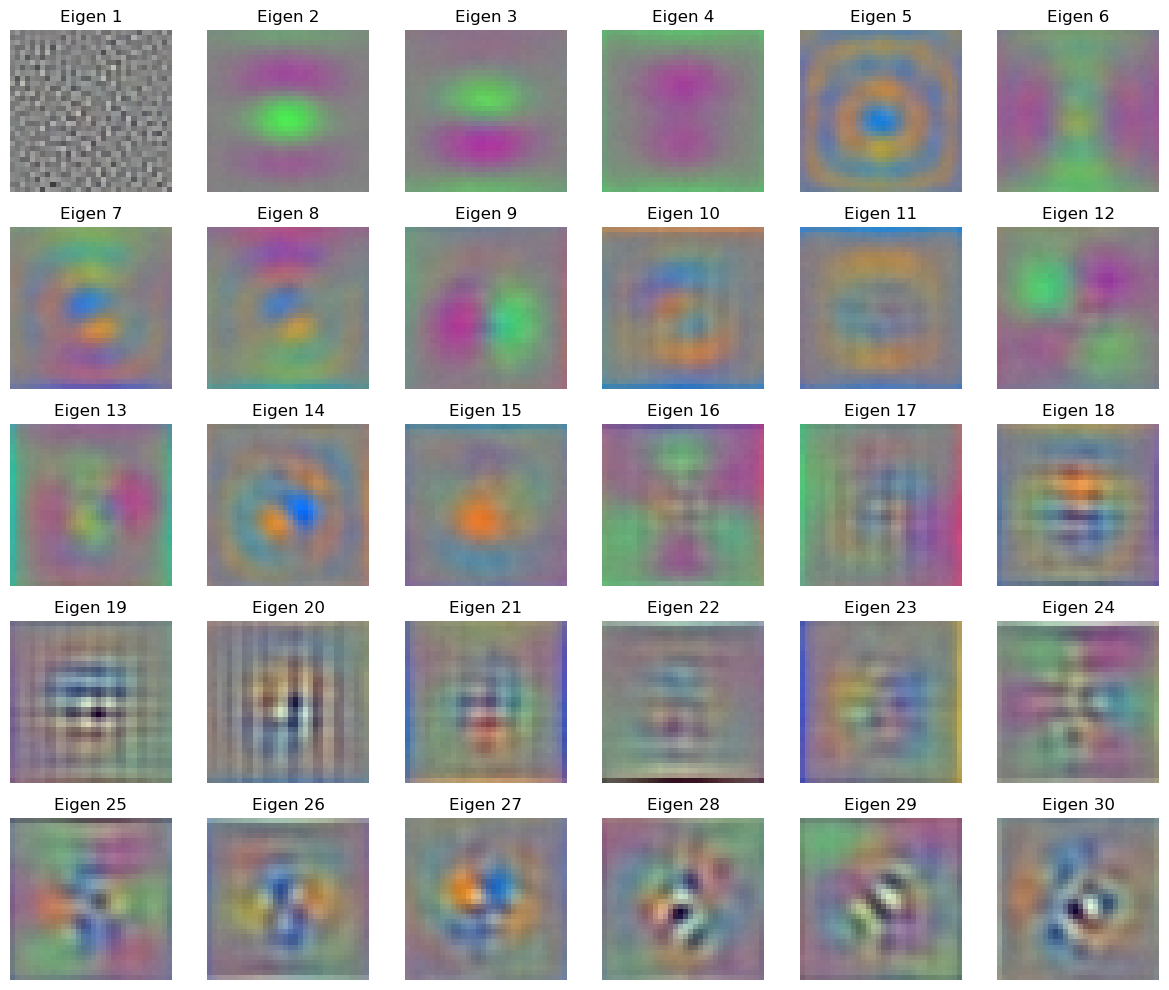

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from transformers import ViTModel

# Load ViT model
model_name = "google/vit-large-patch32-224-in21k"
model = ViTModel.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

# Extract patch embedding weights (projection matrix)
E = model.embeddings.patch_embeddings.projection.weight  # Shape: (1024, 3, 32, 32)
E = rearrange(E, 'c k h w -> c (h w k)')  # Shape: (1024, 3*32*32)

# Convert tensor to NumPy
E_np = E.detach().numpy()  # Shape: (1024, 3*32*32)

# Compute covariance matrix on the embedding weights
cov_matrix = np.cor(E_np, rowvar=False)  # Shape: (3*32*32, 3*32*32)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 30 eigenvectors
top_30_eigenvectors = eigenvectors[:, :30].astype(np.float32)  # Shape: (3*32*32, 30)

# **Back-project into image space**
# Each eigenvector represents a transformation in the original patch space (3×32×32)
reconstructed_patches = rearrange(top_30_eigenvectors, '(h w c) t -> t c h w', h=32, w=32, c=3)  # (30, 3, 32, 32)

# Normalize for visualization (scale to 0-1)
reconstructed_patches = (reconstructed_patches - reconstructed_patches.min()) / (reconstructed_patches.max() - reconstructed_patches.min())

# **Display as images**
fig, axes = plt.subplots(5, 6, figsize=(12, 10))  # Arrange in a 5x6 grid
axes = axes.flatten()
for i in range(30):
    img = reconstructed_patches[i].transpose(1, 2, 0)  # Convert (3, 32, 32) → (32, 32, 3) for plotting
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Eigen {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Flatten the patch embeddings
pca = PCA(n_components=100)
pca.fit(ET.detach().numpy())

# get the first eigenvector
eigenvector = pca.components_[0]
eigenvector.shape # 3072=3*32*32

eigenvector_img = eigenvector.reshape(3, 32, 32)
eigenvector_img = (eigenvector_img - eigenvector_img.min()) / (eigenvector_img.max() - eigenvector_img.min())
plt.imshow(eigenvector_img.transpose(2, 1, 0))

plt.show()


ValueError: cannot reshape array of size 1024 into shape (3,32,32)

In [30]:

# Apply PCA separately to each channel (reduce from 1024 → 3 principal components per channel)
pca = PCA(n_components=10)
principal_components = np.zeros((num_patches, 3, patch_size, patch_size))  # Prepare array for reconstructed images

for c in range(3):  # Loop over R, G, B channels
    transformed = pca.fit_transform(flattened_patches[:, c, :])  # Shape: (1024, 3)
    reconstructed = pca.inverse_transform(transformed)  # Back to (1024, 1024)
    principal_components[:, c, :, :] = reconstructed.reshape(num_patches, patch_size, patch_size)

# Select first 28 filters for visualization
num_filters = 28
fig, axes = plt.subplots(4, 7, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < num_filters:
        img = principal_components[i].transpose(1, 2, 0)  # Convert (3, 32, 32) → (32, 32, 3)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] range
        ax.imshow(img)
        ax.axis("off")

plt.suptitle("RGB Embedding Filters (First 28 Principal Components)")
plt.show()

NameError: name 'num_patches' is not defined